# Predict ETH price direction - Random Forest Classifier

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests
import datetime 

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_6.csv', parse_dates=True)

In [3]:
# Read in combined ETH Google trends data
eth_google_trends = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_google_trends/eth_trends_combined.csv', parse_dates=True)
eth_google_trends.reset_index(inplace=True)
eth_google_trends.rename(columns={'date':'time', 'ethereum':'ETH_Trends'},inplace=True)
eth_google_trends = eth_google_trends.drop(columns='index')
eth_google_trends['time'] = pd.to_datetime(eth_google_trends['time']).dt.date
eth_google_trends = eth_google_trends.set_index('time')
eth_google_trends.tail()

,ETH_Trends
time,
2021-11-28,38
2021-12-05,37
2021-12-12,33
2021-12-19,31
2021-12-26,30


In [4]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')
combined_df.tail()

,time,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
346,2021-12-13 00:00:00+00:00,eth,610120,1.698278,4.452681e+11,877.486094,37.563468,3788.082337,1.175445e+08,1242978,1.185375e+10,18.892499
347,2021-12-14 00:00:00+00:00,eth,617852,1.719872,4.526614e+11,878.316915,39.143196,3850.763308,1.175511e+08,1214900,1.156424e+10,18.881284
348,2021-12-15 00:00:00+00:00,eth,607024,1.773629,4.720652e+11,878.531504,47.901188,4015.642312,1.175566e+08,1258462,9.854978e+09,18.863606
349,2021-12-16 00:00:00+00:00,eth,601544,1.758465,4.671211e+11,857.226757,48.596247,3973.451095,1.175605e+08,1155456,9.612287e+09,18.833360
350,2021-12-17 00:00:00+00:00,eth,615024,1.731316,4.567951e+11,853.830893,51.870505,3885.430082,1.175662e+08,1270355,8.806451e+09,18.772575


In [5]:
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [6]:
# Remove timestamp in time column
combined_df['time'] = pd.to_datetime(combined_df['time']).dt.date
combined_df = combined_df.set_index('time')
combined.to_csv('resources/eth_annual_metrics/combined.csv')

In [7]:
# Concat metrics and google trends data
combined_df = pd.concat([combined_df,eth_google_trends],axis=1).dropna()
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index':'time'})
combined_df = combined_df.set_index('time')
combined_df.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends
time,,,,,,,,,,,,
2016-01-01,eth,2433.0,2.166056,7.010116e+07,0.483217,264.814266,0.920370,7.616628e+07,8233.0,264718.210777,1.362126,8.0
2016-01-02,eth,2486.0,2.226491,7.238322e+07,0.480767,370.221897,0.949990,7.619366e+07,9164.0,195513.065884,1.365054,4.0
2016-01-03,eth,2528.0,2.238090,7.294862e+07,0.494175,234.211669,0.957063,7.622134e+07,9258.0,311464.489292,1.369430,4.0
2016-01-04,eth,2623.0,2.222385,7.243632e+07,0.491670,626.141010,0.950000,7.624876e+07,9474.0,115686.914897,1.370961,5.0
2016-01-05,eth,2620.0,2.207573,7.189832e+07,0.492788,111.469298,0.942600,7.627660e+07,16430.0,645005.606026,1.384049,8.0


In [8]:
# Read in Relative Strength Index (RSI) data
rsi_eth = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/rsi_eth.csv', parse_dates=True, index_col='time')
rsi_eth.head()

,RSI_14
time,
2016-01-15,84.969870
2016-01-16,73.199592
2016-01-17,77.421415
2016-01-18,82.161744
2016-01-19,70.537567


In [9]:
# Read in Rate of Change (ROC) data
roc_eth = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/roc_eth.csv', parse_dates=True, index_col='time')
roc_eth.head()

,ROC_14
time,
2016-01-15,40.257836
2016-01-16,27.558185
2016-01-17,36.974993
2016-01-18,54.341493
2016-01-19,43.544091


In [10]:
# Read in Money Flow Index (MFI) data
mfi_eth = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/mfi_eth.csv', parse_dates=True)
mfi_eth = mfi_eth.rename(columns={'Date':'time'})
mfi_eth['time'] = pd.to_datetime(mfi_eth['time']).dt.date
mfi_eth = mfi_eth.set_index('time').dropna()
mfi_eth.head()

,MFI_14
time,
2017-11-23,71.061607
2017-11-24,79.997218
2017-11-25,81.373298
2017-11-26,80.565557
2017-11-27,81.611830


In [11]:
# Read in True Strength (TSI) data
tsi_eth = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/tsi_eth.csv', parse_dates=True)
tsi_eth = tsi_eth.rename(columns={'Date':'time'})
tsi_eth['time'] = pd.to_datetime(tsi_eth['time']).dt.date
tsi_eth = tsi_eth.set_index('time').dropna()
tsi_eth.head()

,TSI_13_25_13,TSIs_13_25_13
time,,
2016-02-19,36.723593,55.155104
2016-02-20,33.186631,52.016751
2016-02-21,31.275368,49.053696
2016-02-22,32.410383,46.676080
2016-02-23,33.287523,44.763429


In [12]:
# Create model features dataframe
features_eth = pd.concat([combined_df,rsi_eth,roc_eth,mfi_eth,tsi_eth],axis=1).dropna()
features_eth.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends,RSI_14,ROC_14,MFI_14,TSI_13_25_13,TSIs_13_25_13
time,,,,,,,,,,,,,,,,,
2017-11-23,eth,250344.0,1.955830,3.980218e+10,108.864341,19.882259,414.980221,9.591344e+07,537068.0,2.001894e+09,42.955422,34.0,77.132742,29.906391,71.061607,32.254632,16.598001
2017-11-24,eth,242143.0,2.177562,4.541994e+10,111.800532,21.711347,473.450565,9.593385e+07,525529.0,2.091991e+09,43.085554,48.0,83.557891,57.993685,79.997218,40.243095,19.975872
2017-11-25,eth,236910.0,2.129743,4.479168e+10,112.097112,22.295943,466.802905,9.595416e+07,561166.0,2.008961e+09,43.234571,46.0,80.778913,47.653365,81.373298,44.717969,23.510457
2017-11-26,eth,252960.0,2.136961,4.532666e+10,110.937699,26.683421,472.277975,9.597453e+07,542484.0,1.698682e+09,43.383654,42.0,81.329664,53.747922,80.565557,48.205372,27.038302
2017-11-27,eth,277958.0,2.096252,4.585175e+10,108.314055,18.637635,477.648247,9.599480e+07,608695.0,2.460170e+09,43.578673,52.0,81.878157,51.376284,81.611830,51.049354,30.468452


In [13]:
features_eth.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/features_eth.csv')

<AxesSubplot:title={'center':'EMA ETH'}, xlabel='time', ylabel='ETH Price ($)'>

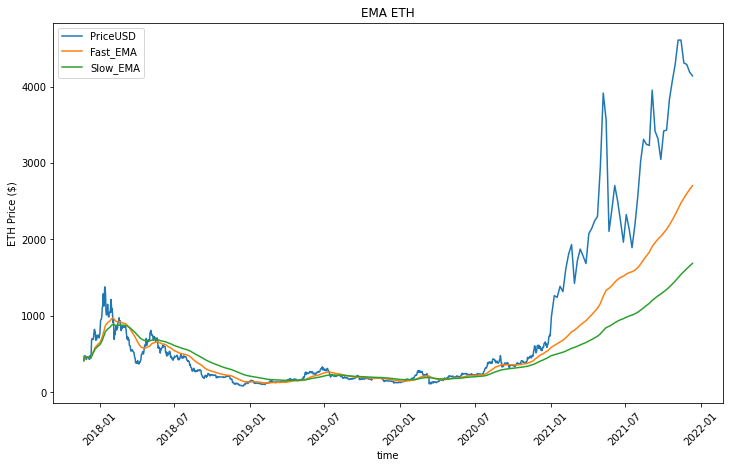

In [14]:
# Set short and long windows for EMA (Exponential Moving Average) to create trading signals feature
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
features_eth['Fast_EMA'] = features_eth['PriceUSD'].ewm(halflife=short_window).mean()
features_eth['Slow_EMA'] = features_eth['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
features_eth[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA ETH', ylabel='ETH Price ($)', rot=45) 

In [15]:
# Construct a crossover trading signal
features_eth['Crossover_Long'] = np.where(features_eth['Fast_EMA'] > features_eth['Slow_EMA'], 1.0, 0.0)
features_eth['Crossover_Short'] = np.where(features_eth['Fast_EMA'] < features_eth['Slow_EMA'],-1.0, 0.0)
features_eth['Crossover_Signal'] = features_eth['Crossover_Long'] + features_eth['Crossover_Short']

In [16]:
# Calculate daily return
features_eth['Daily_Return'] = features_eth['PriceUSD'].pct_change()

In [18]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
features_eth['Positive_Return'] = np.where(features_eth['Daily_Return'] > 0, 1.0, 0.0)

features_eth = features_eth.dropna()

# Convert date to str to set test and train windows 
features_eth.index = pd.to_datetime(features_eth.index, format = '%Y/%m/%d')
features_eth.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,...,MFI_14,TSI_13_25_13,TSIs_13_25_13,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
time,,,,,,,,,,,,,,,,,,,,,
2021-11-14,eth,643454.0,2.033260,5.414160e+11,807.093097,81.708889,4609.516567,1.174561e+08,1275744.0,6.626158e+09,...,53.288081,27.813401,29.381134,2478.200874,1542.554432,1.0,0.0,1.0,0.000049,1.0
2021-11-21,eth,607664.0,1.891318,5.062956e+11,791.233886,61.950593,4310.080434,1.174678e+08,1260939.0,8.172571e+09,...,42.640101,4.906720,17.102974,2540.601417,1580.655784,1.0,0.0,1.0,-0.064960,0.0
2021-11-28,eth,527847.0,1.882997,5.041282e+11,804.139552,87.552164,4291.079171,1.174828e+08,1135653.0,5.758032e+09,...,39.728090,-2.119553,5.584388,2600.229115,1617.970986,1.0,0.0,1.0,-0.004409,0.0
2021-12-05,eth,827717.0,1.831570,4.923839e+11,842.520675,53.732576,4190.580693,1.174978e+08,1386491.0,9.163601e+09,...,49.221584,-0.886920,2.777911,2654.402328,1653.388867,1.0,0.0,1.0,-0.023420,0.0
2021-12-12,eth,597667.0,1.813299,4.867245e+11,849.290525,120.221777,4140.987691,1.175383e+08,1181898.0,4.048555e+09,...,55.516612,-5.111583,-0.980746,2705.040883,1687.636377,1.0,0.0,1.0,-0.011834,0.0


In [19]:
# Select model features and timeframe for train data
X = features_eth[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal','ETH_Trends','RSI_14', 'ROC_14','MFI_14','TSI_13_25_13','TSIs_13_25_13']]
X_train = X.loc['2016':'2020']

In [20]:
# Select prediction variable and timeframe for train data
y = features_eth['Positive_Return']
y_train = y['2016':'2020']

In [21]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [22]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [23]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [24]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [51]:
# Create the decision tree classifier instance and calculate the optimal tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))

Best: 0.665723 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 500}


In [25]:
# Define the model using optimized settings (also use if you want to run without optimizer above)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(n_jobs=-1)
model = RandomForestClassifier(criterion='entropy', max_depth=10,n_estimators=500, n_jobs=-1)

In [26]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [27]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [28]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [29]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,13,8
Actual 1,2,27


Accuracy Score : 0.8
Classification Report
              precision    recall  f1-score   support

         0.0       0.87      0.62      0.72        21
         1.0       0.77      0.93      0.84        29

    accuracy                           0.80        50
   macro avg       0.82      0.78      0.78        50
weighted avg       0.81      0.80      0.79        50



In [30]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-20:]

,Positive_Return,Predicted Value
time,,
2021-08-01,1.0,1.0
2021-08-08,1.0,1.0
2021-08-15,1.0,1.0
2021-08-22,0.0,1.0
2021-08-29,0.0,1.0
2021-09-05,1.0,1.0
2021-09-12,0.0,1.0
2021-09-19,0.0,0.0
2021-09-26,0.0,0.0


In [31]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.14496724891931598, 'RSI_14'),
 (0.09296770300842004, 'TSI_13_25_13'),
 (0.08067895347092531, 'MFI_14'),
 (0.0793960858135654, 'ROC_14'),
 (0.06978256424221406, 'TSIs_13_25_13'),
 (0.06665347987250919, 'NVTAdj'),
 (0.06450068748342942, 'TxCnt'),
 (0.06100225161691674, 'CapMVRVCur'),
 (0.060811254643072715, 'TxTfrValAdjUSD'),
 (0.05855127625395896, 'AdrActCnt'),
 (0.05821290700129293, 'CapMrktCurUSD'),
 (0.05770474960199112, 'HashRate'),
 (0.05305869445122625, 'VelCur1yr'),
 (0.04904746562845694, 'ETH_Trends'),
 (0.002664677992704845, 'Crossover_Signal')]

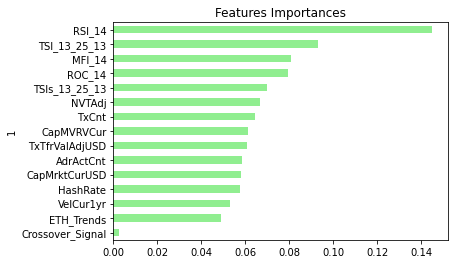

In [32]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)

In [ ]:
# RSI is the most dominant feature which shows that ETH price is primarily determined by momentum.